# Telco Customer Churn – Guided Notebook (nbformat)

This notebook mirrors the Python scripts (`telco_churn.py`, `best_model_predict.py`) with structured explanations and code.
It includes the problem statement, EDA, preprocessing, modeling (baseline and SMOTEENN), sample predictions, and final conclusions.


## Problem Statement

Predict whether a customer will churn (Yes/No) based on demographics, services, and account details.
High-quality predictions help prioritize retention actions.


## Setup

We import libraries for data handling, visualization, preprocessing, modeling, and evaluation.
We also set common paths to the dataset and output directories.


In [18]:
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from imblearn.combine import SMOTEENN

here = os.getcwd()
csv_path = os.path.join(here, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
outputs_dir = os.path.join(here, 'outputs')
docs_dir = os.path.join(here, 'docs')
assert os.path.exists(csv_path), f'Dataset not found at {csv_path}. Place the CSV next to this notebook.'


## Load and Preview Data

We load the CSV, display schema info, and preview rows to understand the feature set.


In [19]:
df = pd.read_csv(csv_path)
pd.set_option('display.max_columns', None)
display(df.head())
display(df.info())


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

## Cleaning and EDA – What and Why

- Coerce `TotalCharges` to numeric, drop rows that become NA.
- Drop `customerID` (identifier, no predictive signal).
- Visualize missingness and key distributions to form hypotheses.


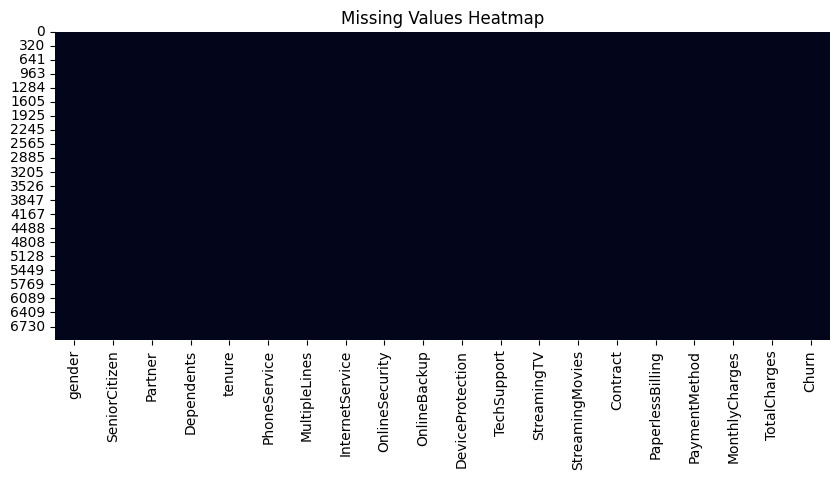

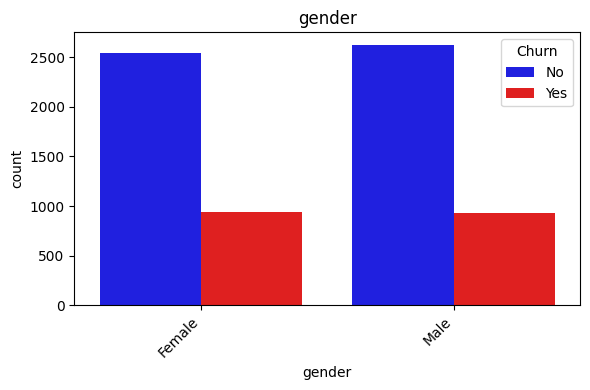

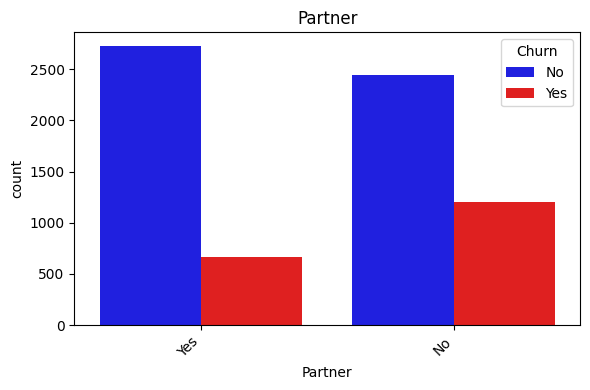

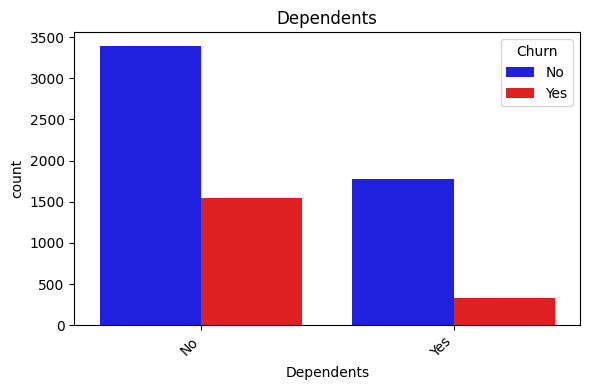

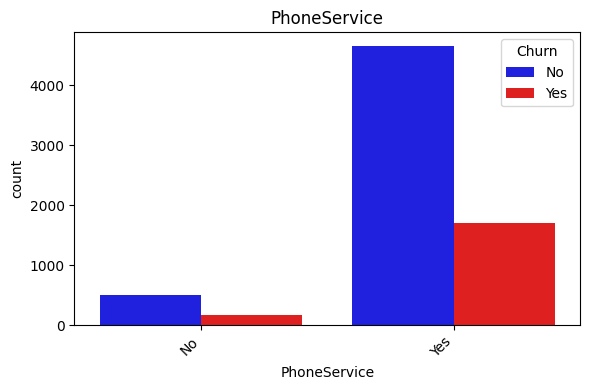

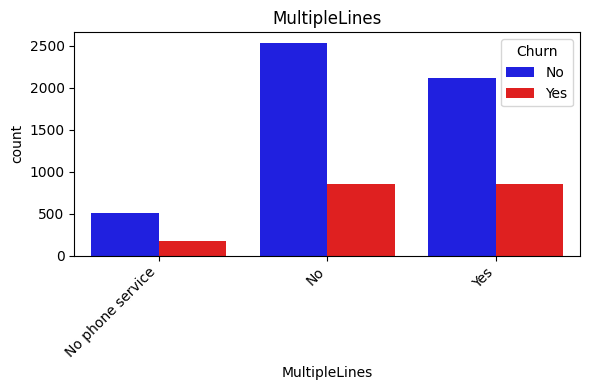

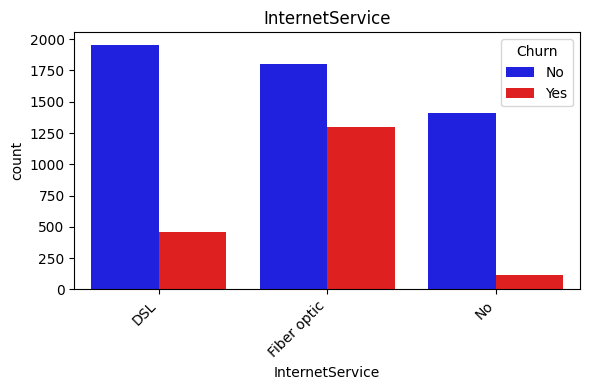

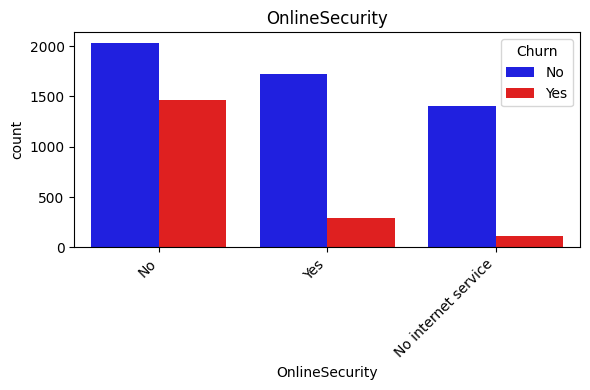

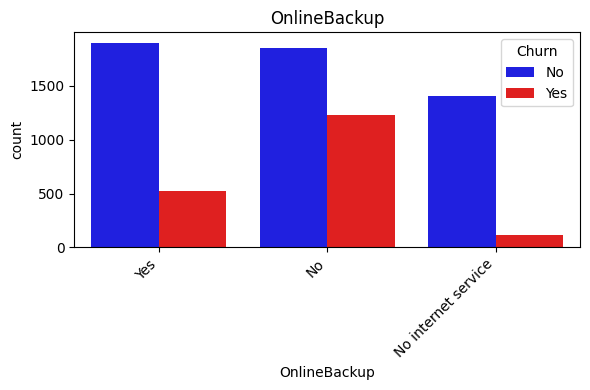

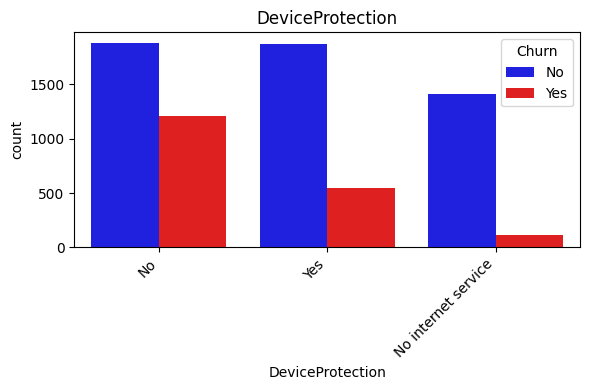

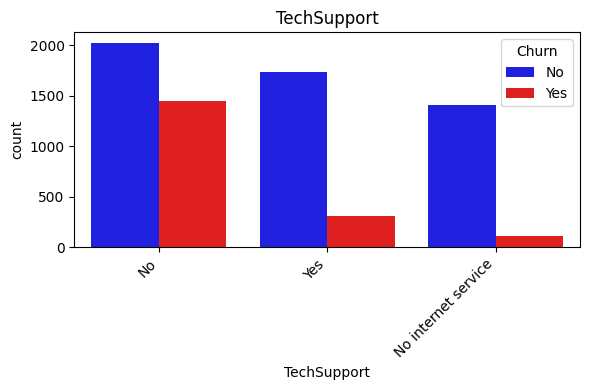

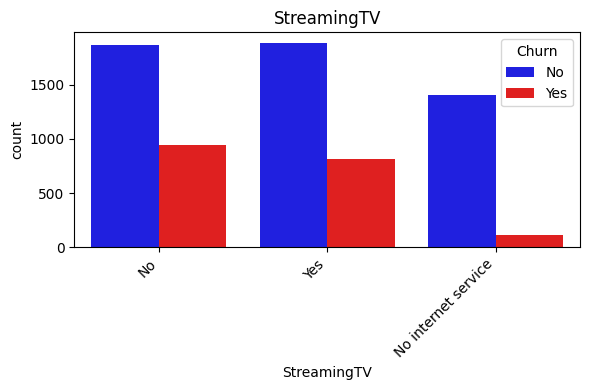

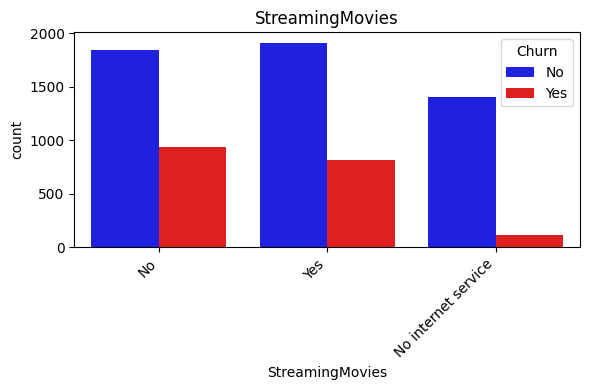

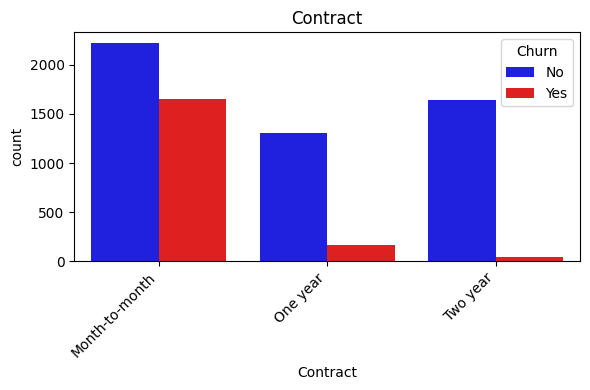

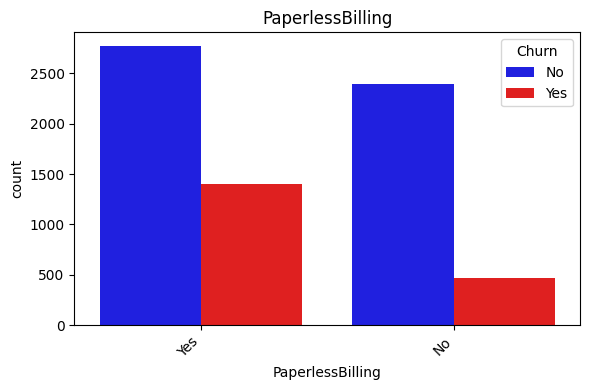

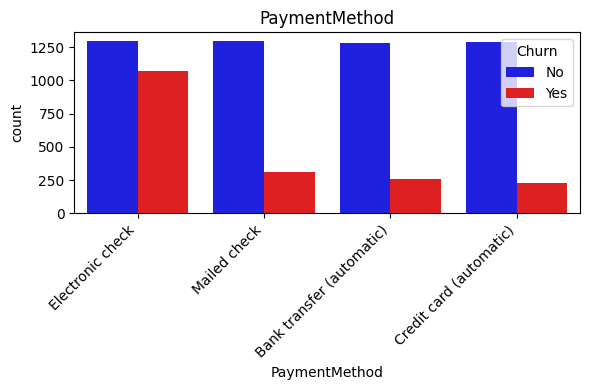

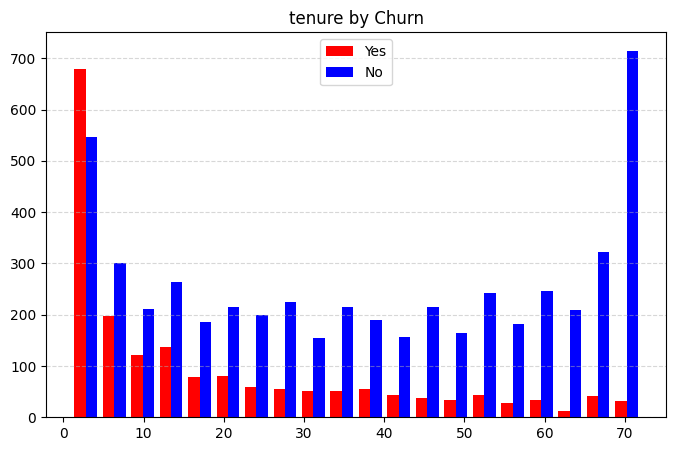

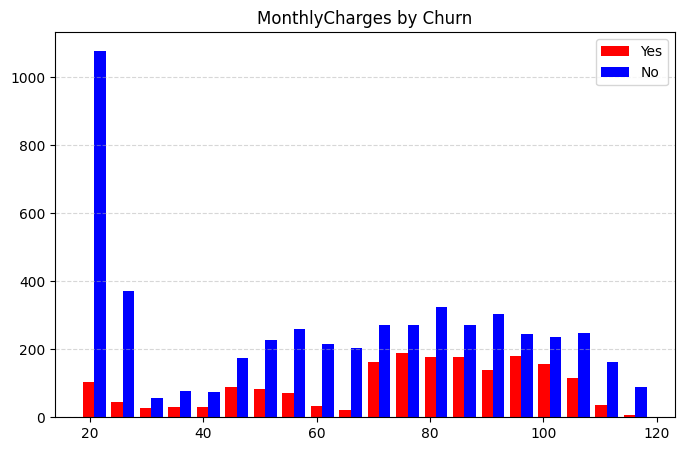

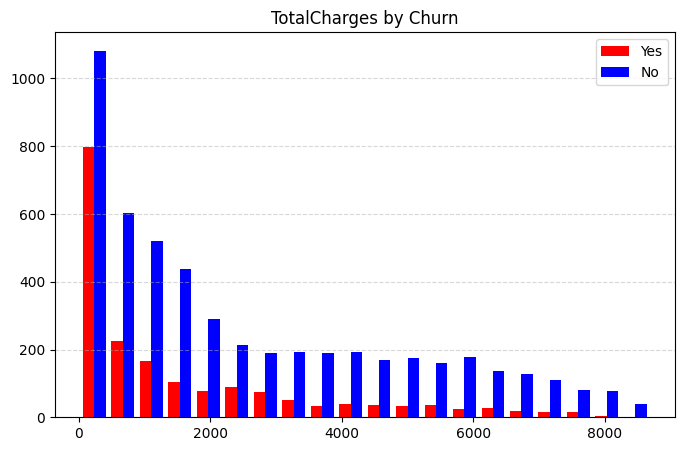

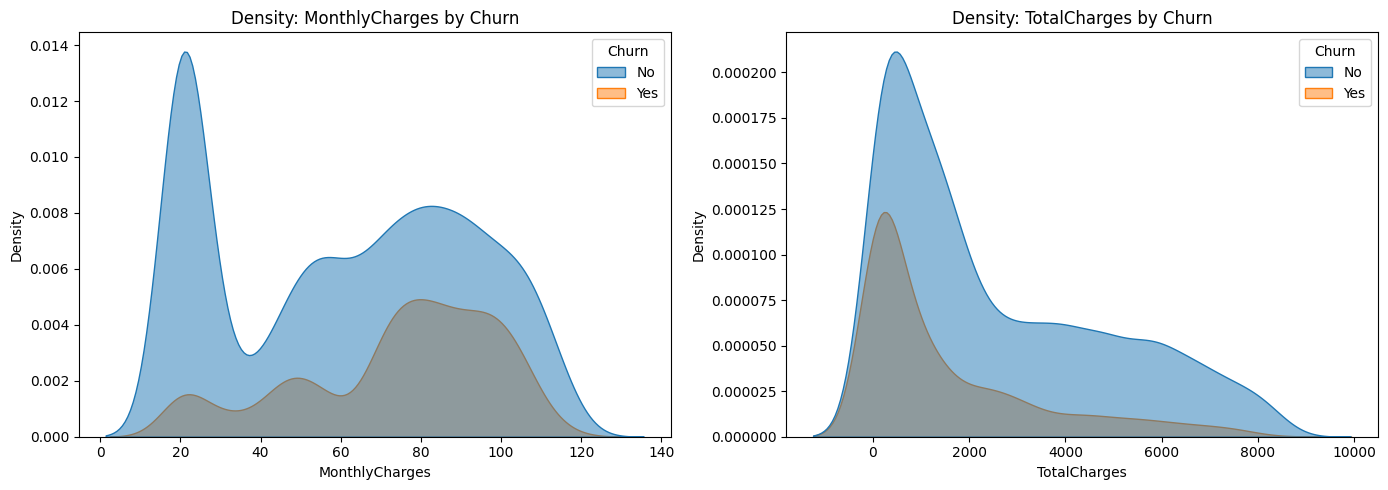

In [20]:
# Clean
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Missing heatmap
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

# Categorical distributions vs Churn
colors = {'Yes': 'red', 'No': 'blue'}
for col in df.select_dtypes(include=['object','category']).columns:
    if col != 'Churn':
        plt.figure(figsize=(6,4))
        sns.countplot(data=df, x=col, hue='Churn', palette=colors)
        plt.title(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Numeric distributions
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        plt.figure(figsize=(8,5))
        plt.hist([df[df['Churn']=='Yes'][col], df[df['Churn']=='No'][col]], bins=20, color=['red','blue'], label=['Yes','No'])
        plt.title(f'{col} by Churn')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Density: MonthlyCharges by Churn')
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Density: TotalCharges by Churn')
plt.tight_layout()
plt.show()


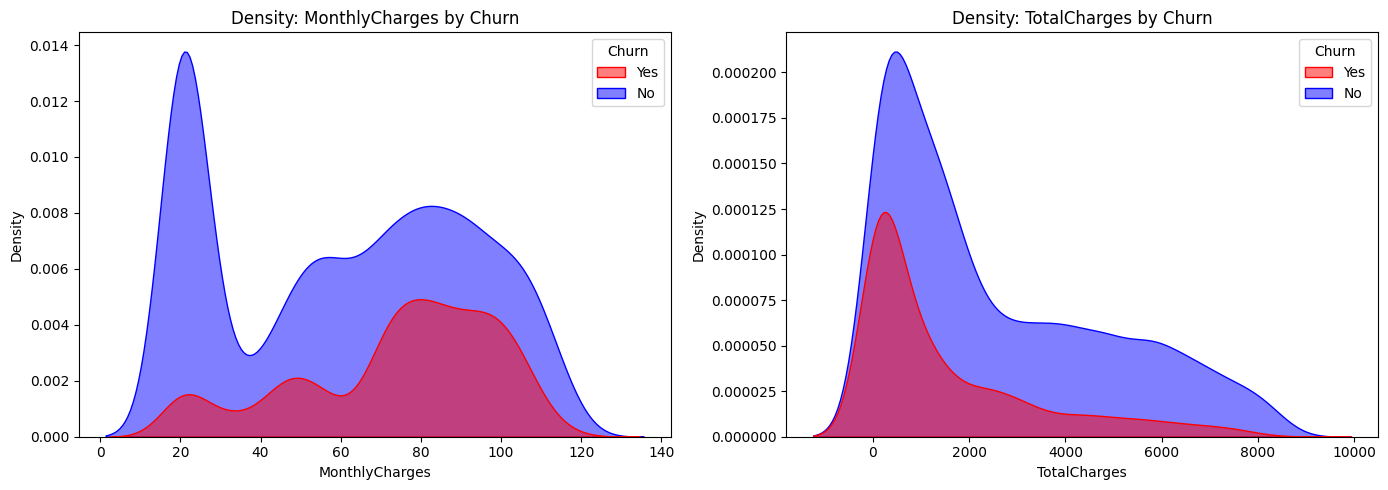

In [29]:
# Force consistent colors for KDE plots
palette = {'Yes': 'red', 'No': 'blue'}
hue_order = ['Yes', 'No']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(
    data=df, x='MonthlyCharges', hue='Churn',
    fill=True, alpha=0.5,
    palette=palette, hue_order=hue_order,
    ax=axes[0]
)
axes[0].set_title('Density: MonthlyCharges by Churn')

sns.kdeplot(
    data=df, x='TotalCharges', hue='Churn',
    fill=True, alpha=0.5,
    palette=palette, hue_order=hue_order,
    ax=axes[1]
)
axes[1].set_title('Density: TotalCharges by Churn')

plt.tight_layout()
plt.show()

In [28]:
df.isnull().sum().sort_values(ascending=False).head(10)

gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
OnlineBackup       0
dtype: int64

## Key EDA Takeaways

- Lower tenure and month-to-month contracts are associated with higher churn.
- Fiber optic internet users churn more than DSL in this dataset.
- Electronic check, paperless billing, and lack of OnlineSecurity/TechSupport indicate higher churn.
- Moderate charges are safer; very high charges increase churn risk.
-


## One-Hot Encoding – What are we doing next?

We convert categorical variables into binary indicator columns and produce a single `Churn` binary target.


In [21]:
cat_cols = df.select_dtypes(include=['object','category']).columns
try:
    encoder = OneHotEncoder(sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(sparse=False)
enc = encoder.fit_transform(df[cat_cols])
enc_df = pd.DataFrame(enc, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
df_num = df.drop(columns=cat_cols)
df_enc = pd.concat([df_num, enc_df], axis=1)
if 'Churn_Yes' in df_enc.columns:
    if 'Churn_No' in df_enc.columns:
        df_enc.drop('Churn_No', axis=1, inplace=True)
    df_enc.rename(columns={'Churn_Yes':'Churn'}, inplace=True)
display(df_enc.head())


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,29.85,29.85,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,34,56.95,1889.50,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,2,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0,45,42.30,1840.75,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,2,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Split Data – Why now?

We create train/test splits to estimate generalization performance and avoid overfitting.


In [22]:
X = df_enc.drop('Churn', axis=1)
y = df_enc['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((5625, 45), (1407, 45))

## Baseline Models – What we test and expect

We evaluate several models with light grids to compare baseline performance without imbalance handling.


,Model,Accuracy
0,Random Forest,0.795309
1,Gradient Boosting,0.791756
7,XGBoost,0.787491
6,AdaBoost,0.783937
4,KNN,0.753376
5,Decision Tree,0.753376
2,SVM,0.730633
3,Logistic Regression,0.729922
8,Naive Bayes,0.683724


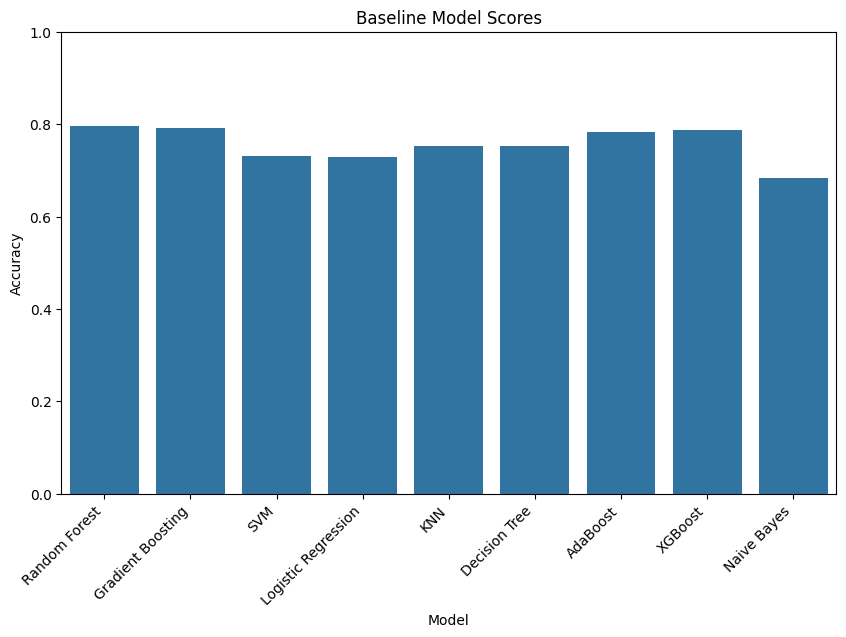

Best baseline accuracy: 0.795


In [23]:
models = [
    ('Random Forest', RandomForestClassifier(random_state=42), {'model__n_estimators':[50,100], 'model__max_depth':[None,10,20]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42), {'model__n_estimators':[50,100], 'model__learning_rate':[0.05,0.1]}),
    ('SVM', SVC(random_state=42, class_weight='balanced'), {'model__C':[0.1,1,10], 'model__gamma':['scale','auto']}),
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'), {'model__C':[0.1,1,10], 'model__penalty':['l1','l2']}),
    ('KNN', KNeighborsClassifier(), {'model__n_neighbors':[3,5,7], 'model__weights':['uniform','distance']}),
    ('Decision Tree', DecisionTreeClassifier(random_state=42), {'model__max_depth':[None,10,20], 'model__min_samples_split':[2,5,10]}),
    ('AdaBoost', AdaBoostClassifier(random_state=42), {'model__n_estimators':[50,100], 'model__learning_rate':[0.05,0.1]}),
    ('XGBoost', XGBClassifier(random_state=42), {'model__n_estimators':[50,100], 'model__learning_rate':[0.05,0.1]}),
    ('Naive Bayes', GaussianNB(), {})
]
scores = []
best_pipe, best_acc = None, 0.0
for name, model, grid in models:
    pipe = Pipeline([('scaler', MinMaxScaler()), ('model', model)])
    if grid:
        gs = GridSearchCV(pipe, grid, cv=2, n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train); pipe = gs.best_estimator_
    else:
        pipe.fit(X_train, y_train)
    acc = accuracy_score(y_test, pipe.predict(X_test))
    scores.append({'Model': name, 'Accuracy': acc})
    if acc > best_acc: best_acc, best_pipe = acc, pipe
import pandas as pd
scores_df = pd.DataFrame(scores)
display(scores_df.sort_values('Accuracy', ascending=False))
plt.figure(figsize=(10,6)); sns.barplot(x='Model', y='Accuracy', data=scores_df); plt.xticks(rotation=45, ha='right'); plt.ylim(0,1); plt.title('Baseline Model Scores'); plt.show()
print('Best baseline accuracy:', round(best_acc,3))


## SMOTEENN Modeling – What changes and why

SMOTEENN balances the dataset by combining over/under-sampling. We re-run model selection.


,Model,Accuracy
2,SVM,0.984784
4,KNN,0.978022
7,XGBoost,0.956044
1,Gradient Boosting,0.954353
0,Random Forest,0.951817
5,Decision Tree,0.933221
6,AdaBoost,0.919696
3,Logistic Regression,0.906171
8,Naive Bayes,0.875740


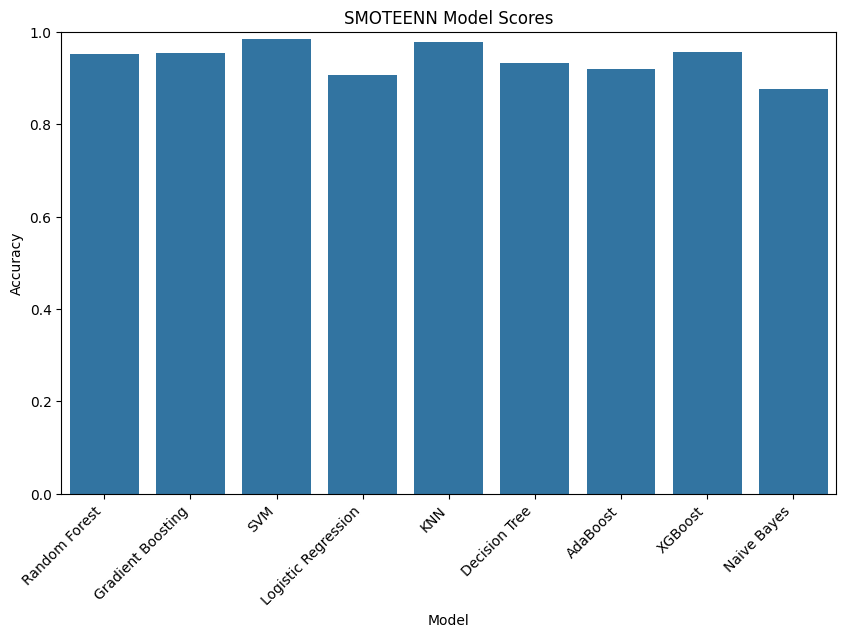

Best SMOTEENN accuracy: 0.985


In [24]:
sm = SMOTEENN(); X_res, y_res = sm.fit_resample(X, y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
models2 = [
    ('Random Forest', RandomForestClassifier(random_state=42), {'n_estimators':[50,100], 'max_depth':[None,10,20]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42), {'n_estimators':[50,100], 'learning_rate':[0.05,0.1]}),
    ('SVM', SVC(random_state=42, class_weight='balanced'), {'C':[0.1,1,10], 'gamma':['scale','auto']}),
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'), {'C':[0.1,1,10], 'penalty':['l1','l2']}),
    ('KNN', KNeighborsClassifier(), {'n_neighbors':[3,5,7], 'weights':['uniform','distance']}),
    ('Decision Tree', DecisionTreeClassifier(random_state=42), {'max_depth':[None,10,20], 'min_samples_split':[2,5,10]}),
    ('AdaBoost', AdaBoostClassifier(random_state=42), {'n_estimators':[50,100], 'learning_rate':[0.05,0.1]}),
    ('XGBoost', XGBClassifier(random_state=42), {'max_depth':[3,5], 'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'subsample':[0.8,1.0]}),
    ('Naive Bayes', GaussianNB(), {})
]
scores2 = []; best_model2, best_acc2 = None, 0.0
for name, model, grid in models2:
    if name == 'XGBoost' and grid:
        rs = RandomizedSearchCV(model, grid, n_iter=20, cv=3, n_jobs=-1, random_state=42, verbose=0)
        rs.fit(Xr_train, yr_train); best_est = rs.best_estimator_
    elif grid:
        gs = GridSearchCV(model, grid, cv=2, n_jobs=-1, verbose=0)
        gs.fit(Xr_train, yr_train); best_est = gs.best_estimator_
    else:
        best_est = model.fit(Xr_train, yr_train)
    acc = accuracy_score(yr_test, best_est.predict(Xr_test))
    scores2.append({'Model': name, 'Accuracy': acc})
    if acc > best_acc2: best_acc2, best_model2 = acc, best_est
scores_df2 = pd.DataFrame(scores2)
display(scores_df2.sort_values('Accuracy', ascending=False))
plt.figure(figsize=(10,6)); sns.barplot(x='Model', y='Accuracy', data=scores_df2); plt.xticks(rotation=45, ha='right'); plt.ylim(0,1); plt.title('SMOTEENN Model Scores'); plt.show()
print('Best SMOTEENN accuracy:', round(best_acc2,3))


## Confusion Matrix – Why it matters

We visualize the confusion matrix to understand error types.


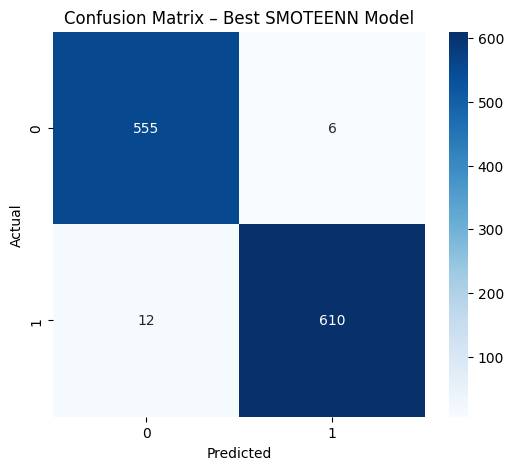

In [25]:
cm = confusion_matrix(yr_test, best_model2.predict(Xr_test))
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix – Best SMOTEENN Model'); plt.show()


## Four Example Predictions – With Explanations
We select 2 predicted Yes + 2 predicted No examples and explain them using human-readable rules derived from EDA.


In [26]:
def explain_row(raw_row: pd.Series) -> list:
    reasons = []
    reasons.append('Low tenure (<= 12 months) increases churn risk.' if raw_row.get('tenure', 13) <= 12 else 'Higher tenure (> 12 months) reduces churn risk.')
    reasons.append('Month-to-month contract is associated with higher churn.' if raw_row.get('Contract') == 'Month-to-month' else f"Longer contract ({raw_row.get('Contract')}) is associated with lower churn.")
    if raw_row.get('InternetService') == 'Fiber optic': reasons.append('Fiber optic users show higher churn on average.')
    if raw_row.get('InternetService') == 'DSL': reasons.append('DSL tends to show lower churn than Fiber optic.')
    pm = str(raw_row.get('PaymentMethod'))
    reasons.append('Electronic check payment is correlated with higher churn.' if 'Electronic check' in pm else 'Automatic bank/credit payments correlate with lower churn.')
    mc = float(raw_row.get('MonthlyCharges', 0))
    reasons.append('High MonthlyCharges (>= 80) often correlate with higher churn.' if mc >= 80 else 'Moderate MonthlyCharges correlate with lower churn.')
    for svc in ['OnlineSecurity','TechSupport']:
        v = raw_row.get(svc)
        if v == 'No': reasons.append(f'No {svc} is associated with higher churn.')
        if v == 'Yes': reasons.append(f'Having {svc} is associated with lower churn.')
    if raw_row.get('PaperlessBilling') == 'Yes': reasons.append('Paperless billing correlates with higher churn.')
    return reasons

df_raw = pd.read_csv(csv_path)
df_raw['TotalCharges'] = pd.to_numeric(df_raw['TotalCharges'], errors='coerce')
df_raw.dropna(inplace=True)
if 'customerID' in df_raw.columns: df_raw.drop('customerID', axis=1, inplace=True)

# Build encoded frame again to align indices
cat_cols_raw = df_raw.select_dtypes(include=['object','category']).columns
try:
    encoder2 = OneHotEncoder(sparse_output=False)
except TypeError:
    encoder2 = OneHotEncoder(sparse=False)
enc2 = encoder2.fit_transform(df_raw[cat_cols_raw])
enc_df2 = pd.DataFrame(enc2, columns=encoder2.get_feature_names_out(cat_cols_raw), index=df_raw.index)
df_num2 = df_raw.drop(columns=cat_cols_raw)
df_enc_full = pd.concat([df_num2, enc_df2], axis=1)
if 'Churn_Yes' in df_enc_full.columns:
    if 'Churn_No' in df_enc_full.columns:
        df_enc_full.drop('Churn_No', axis=1, inplace=True)
    df_enc_full.rename(columns={'Churn_Yes':'Churn'}, inplace=True)
X_full = df_enc_full.drop('Churn', axis=1)
preds_full = best_model2.predict(X_full)
yes_idx = np.where(preds_full==1)[0].tolist()
no_idx = np.where(preds_full==0)[0].tolist()
sel = yes_idx[:2] + no_idx[:2]
for i, idx in enumerate(sel):
    raw = df_raw.iloc[idx]
    pred = 'Yes' if int(preds_full[idx])==1 else 'No'
    print(f'Sample {i+1} – Predicted: {pred}, Actual: {raw.get('Churn', 'Unknown')}')
    snap_cols = ['tenure','MonthlyCharges','TotalCharges','Contract','InternetService','PaymentMethod','OnlineSecurity','TechSupport','PaperlessBilling']
    snap = {c: raw[c] for c in snap_cols if c in raw}
    print('  Features:', snap)
    for r in explain_row(raw): print('   -', r)
    print()


Sample 1 – Predicted: Yes, Actual: No
  Features: {'tenure': np.int64(1), 'MonthlyCharges': np.float64(29.85), 'TotalCharges': np.float64(29.85), 'Contract': 'Month-to-month', 'InternetService': 'DSL', 'PaymentMethod': 'Electronic check', 'OnlineSecurity': 'No', 'TechSupport': 'No', 'PaperlessBilling': 'Yes'}
   - Low tenure (<= 12 months) increases churn risk.
   - Month-to-month contract is associated with higher churn.
   - DSL tends to show lower churn than Fiber optic.
   - Electronic check payment is correlated with higher churn.
   - Moderate MonthlyCharges correlate with lower churn.
   - No OnlineSecurity is associated with higher churn.
   - No TechSupport is associated with higher churn.
   - Paperless billing correlates with higher churn.

Sample 2 – Predicted: Yes, Actual: Yes
  Features: {'tenure': np.int64(2), 'MonthlyCharges': np.float64(53.85), 'TotalCharges': np.float64(108.15), 'Contract': 'Month-to-month', 'InternetService': 'DSL', 'PaymentMethod': 'Mailed check', '

## 20-Sample Check – Quick Accuracy Probe
We evaluate a random set of 20 test samples using the best SMOTEENN model (KNN distance).


In [27]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(Xr_train, yr_train)
full_acc = accuracy_score(yr_test, knn.predict(Xr_test))
rng = np.random.default_rng(42)
idx = np.array(Xr_test.index)
sel20 = idx if len(idx) < 20 else rng.choice(idx, size=20, replace=False)
pred20 = knn.predict(Xr_test.loc[sel20])
acc20 = accuracy_score(yr_test.loc[sel20], pred20)
print('Full test accuracy (KNN/SMOTEENN):', round(full_acc,3))
print('20-sample subset accuracy:', round(acc20,3))
pd.DataFrame({'RowIdx': sel20, 'Actual': ['Yes' if v==1 else 'No' for v in yr_test.loc[sel20]], 'Predicted': ['Yes' if v==1 else 'No' for v in pred20]})


Full test accuracy (KNN/SMOTEENN): 0.978
20-sample subset accuracy: 0.95


,RowIdx,Actual,Predicted
0,2937,Yes,Yes
1,5524,Yes,Yes
2,346,No,No
3,4470,Yes,Yes
4,4732,Yes,Yes
5,3187,Yes,Yes
6,4733,Yes,Yes
7,3615,Yes,Yes
8,432,No,No
9,5505,Yes,Yes


## Final Conclusion
- Influential features: tenure, contract, internet service type, payment method, OnlineSecurity/TechSupport, paperless billing, and charges.
- Best model after SMOTEENN: KNN (n_neighbors=3, weights='distance'), ~0.98 accuracy.
- Errors are expected due to overlapping patterns; calibrate thresholds and track additional metrics.

